## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
       BatchNorm1d-3                   [-1, 50]             100
         LeakyReLU-4                   [-1, 50]               0
           Dropout-5                   [-1, 50]               0
            Linear-6                   [-1, 50]           2,550
         LeakyReLU-7                   [-1, 50]               0
           Dropout-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
       LogSoftmax-10                   [-1, 10]               0
Total params: 42,410
Trainable params: 42,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Tot

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [10]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
  train_loss = []
  val_loss = []
  val_accuracy = []

  for epoch in range(n_epochs):
    ep_train_loss = []
    ep_val_loss = []
    ep_val_accuracy = []

    model.train(True)
    for X_batch, y_batch in train_loader:

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      predictions = model(X_batch)
      loss = loss_fn(predictions, y_batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
      ep_train_loss.append(loss.item())

    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          predictions = model(X_batch)
          loss = loss_fn(predictions, y_batch)
          ep_val_loss.append(loss.item())
          y_pred = predictions.max(1)[1].data
          ep_val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    
    train_loss.append(np.mean(ep_train_loss))
    val_loss.append(np.mean(ep_val_loss))
    val_accuracy.append(np.mean(ep_val_accuracy))

  return train_loss, val_loss, ep_val_accuracy

In [11]:
# model = TinyNeuralNetwork().to(device)
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE

model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()
n_epochs = 40

In [12]:
train_loss, val_loss, val_accuracy = train_model(model, 
                                                 train_loader, 
                                                 test_loader, 
                                                 loss_fn, 
                                                 optimizer, 
                                                 n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [13]:
def plot_process(train_loss, val_loss, val_accuracy):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].set_title("Loss")
  axes[0].plot(train_loss, label='train')
  axes[0].plot(val_loss, label='val')
  axes[0].legend()

  axes[1].set_title("Test accuracy")
  axes[1].plot(val_accuracy)

  fig.show()

0.9375


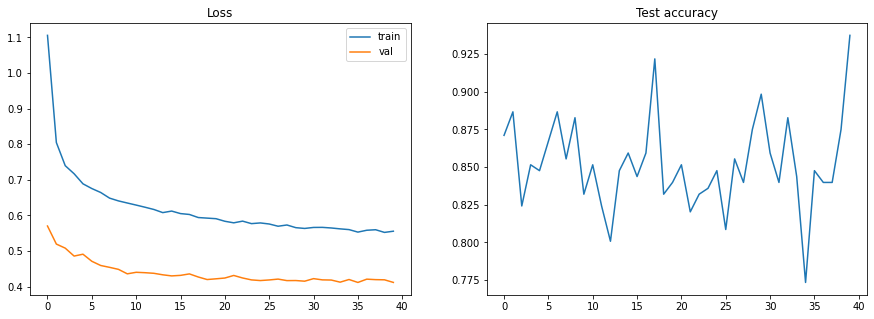

In [14]:
plot_process(train_loss, val_loss, val_accuracy)
print(max(val_accuracy))

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 50),
            nn.LeakyReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
         LeakyReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 50]           5,050
         LeakyReLU-5                   [-1, 50]               0
            Linear-6                   [-1, 10]             510
        LogSoftmax-7                   [-1, 10]               0
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [17]:
model_overfit = OverfittingNeuralNetwork().to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

In [18]:
train_loss, val_loss, val_accuracy = train_model(model_overfit, 
                                                 train_loader, 
                                                 test_loader, 
                                                 loss_fn, 
                                                 optimizer, 
                                                 n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.1875
2.306833023709783


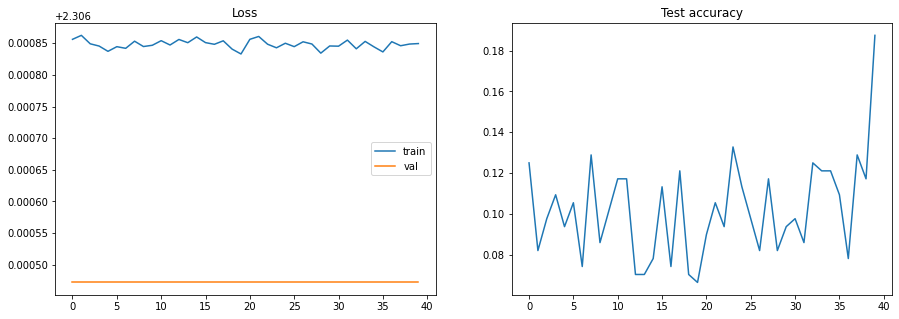

In [19]:
plot_process(train_loss, val_loss, val_accuracy)
print(max(val_accuracy))
print(min(train_loss))

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

*Возвращаемся к первоначальной модели*

### Conclusions:
_Write down small report with your conclusions and your ideas._

Было показано, что модель с линейными слоями не справляется с поставленной задачей. При добавлении BatchNorm промежуточные признаковые пространства нормируются, а Dropout делает модель более устойчивой, что в совокупности приводит к хорошему результату.